# Imports

In [1]:
import h5py
from matplotlib import pyplot as plt
import cv2
import numpy as np
import tensorflow as tf

import math
import random

%matplotlib inline

print("Test")

Test


# Is using GPU?

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4885222781358368616
]


## Load data for later use

In [3]:
FONTS = ['Skylark', 'Ubuntu Mono', 'Sweet Puppy']

file_name = "font_recognition_train_set/SynthText.h5"

db = h5py.File(file_name, "r")
IM_NAMES = list(db["data"].keys())

num_of_images = len(IM_NAMES)
print(f"Number of images: {num_of_images}")

Number of images: 760


## Crop the word with perfect angle - affine transformation

Tutorial that helped me:

https://docs.opencv.org/3.4/d4/d61/tutorial_warp_affine.html

In [4]:
def crop_affine(img, bb):
    """
    Crop image using affine transformation, around bounding box. Returns cropped image.
    """
    img_copy = img.copy()
    width = img_copy.shape[1]
    height = img_copy.shape[0]
        
    point1 = (bb[0][0], bb[1][0]) # Top-left
    point2 = (bb[0][1], bb[1][1]) # Top-right
    point3 = (bb[0][2], bb[1][2]) # Bottom-Right
    point4 = (bb[0][3], bb[1][3]) # Bottom-Left
    
    # Euclidian distance
    bb_width = int(np.linalg.norm(np.array(point1) - np.array(point2)))
    bb_height = int(np.linalg.norm(np.array(point1) - np.array(point3)))

    # Mapping srcPoints (list of points of size 3) to dstPoints (list of points of size 3)
    srcTri = np.array( [point1, point2, point4] ).astype(np.float32)
    dstTri = np.array( [[0, 0], [bb_width, 0], [0, bb_height]] ).astype(np.float32)
    
    # Apply transformation
    warp_mat = cv2.getAffineTransform(srcTri, dstTri)
    warp_dst = cv2.warpAffine(img_copy, warp_mat, (width, height))
    
    # Crop the 'warped' image
    crop = warp_dst[0:bb_height, 0:bb_width]
    
    return crop

## Normalize function

![](images/normalize_formula.png)

In [5]:
def normalize(img, low=0, high=1):
    """
    Normalize image to range [low, high] from any range. Note: fast algorithm.
    """
    return np.interp(img, [np.min(img), np.max(img)], [low, high])

## func: Extract data from image name return json

In [6]:
def extract_data(img_name:str):
    """
    Process the image and returned processed result.
    Return a json in the following structure (as an example):
    {
        "img": <ndarray>,
        "name": "test.png",
        "words": [
            {
                "word": "the",
                "font": "Ubuntu Mono",
                "chars": [
                    {
                        "char": "t",
                        "font": "Ubuntu Mono",
                        "crop": <ndarray>,
                        "bb": <ndarray>
                    }, ...
                ],
                "bb": <ndarray>
                "crop": <ndarray>
            }, ...
        ]
    }
    """
    img = db['data'][img_name][:]                 # The image.
    font = db['data'][img_name].attrs['font']     # Contains list of fonts.
    txt = db['data'][img_name].attrs['txt']       # Contains list of words.
    charBB = db['data'][img_name].attrs['charBB'] # Contains list of bb for words.
    wordBB = db['data'][img_name].attrs['wordBB'] # Contain list of bb for chars.


    words = []
    char_index_accumulator = 0
    word_index = 0 # Counter
    
    # Process word
    for word in txt:
        word_font = font[char_index_accumulator].decode() # Convert bytes to string
        chars = []

        word_bb = wordBB[:, :, word_index]
        word_crop = crop_affine(img, word_bb)

        # Process chars
        for char_index in range(len(word)):
            char = chr(word[char_index])
            char_font = font[char_index_accumulator].decode()
            char_bb = charBB[:, :, char_index_accumulator]
            
            #assert char_font == word_font # Double check that the pre-processed image is indeed 1 font per word, and each char is same font as word.
            
            crop_char = crop_affine(img, char_bb)
            
            chars.append({
                "char": char,
                "font": char_font,
                "crop": crop_char,
                "bb": char_bb
            })
            
            char_index_accumulator += 1

        words.append({
            "word": word.decode(),
            "font": word_font,
            "chars": chars,
            "bb": word_bb,
            "crop": word_crop,
        })
        word_index += 1
    
    # Return result
    return {
        "img": img,
        "name": img_name,
        "words": words,
    }

## func: Plot training sample

In [7]:
def plot_sample(x, y, index):
    """
    Plot sample by given index.
    """
    plt.figure(figsize = (15,2))
    plt.imshow(x[index])
    plt.xlabel(y[index])

## func: Draw bounding box

In [8]:
def draw_bb(bb):
    # Draw bb points
    formats__ = ["rp", "gp", "bp", "wp"]
    colors = ["r", "g", "b", "w"]
    x_line = []
    y_line = []
    for i in range(4):
        x = bb[0][i]
        y = bb[1][i]
        plt.plot(x, y, formats__[i])
        x_line.append(x)
        y_line.append(y)
    x_line.append(bb[0][0])
    y_line.append(bb[1][0])
    plt.plot(x_line, y_line, color="red")

## func: Plot training data with subplots

In [9]:
def plot_train_samples(low=0, high=28, fig_size=8):
    plt.figure(figsize=(fig_size, fig_size))
    j = 0
    
    row_col = round(math.sqrt(high-low))+1
    print(row_col)
    for i in range(low, high):
        plt.subplot(row_col,row_col,j+1)
        j += 1
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_train[i], cmap="gray")
        plt.xlabel(y_train[i])
    plt.show()

## func: Process image and label and append to training set

In [10]:
def append_to_training(x, y):
    # Convert to gray
    try:
        if x.shape[2] != 1:
            x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
    except:
        pass
    # Resize
    if x.shape[0] != avg_cropped_char_height or x.shape[1] != avg_cropped_char_width:
        x = cv2.resize(x, (avg_cropped_char_width, avg_cropped_char_height))
    # Normalize
    x = normalize(x)
    
    # Map y string to float
    if type(y) == str:
        if y == "Ubuntu Mono":
            y = 0
        elif y == "Skylark":
            y = 1
        elif y == "Sweet Puppy":
            y = 2
        else:
            raise "Error font, no such font: " + str(y)
    
    x_train.append(x)
    y_train.append(y)

## func: Make noisy images

In [11]:
def noisy(image, noise_typ="random",):
    row = image.shape[0]
    col = image.shape[1]
    
    if noise_typ == "random":
        noise_typ = random.choice(["gauss", "s&p", "poisson", "speckle"])
    if noise_typ == "gauss":
        mean = 0
        var = 0.007
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col))
        gauss = gauss.reshape(row,col)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        s_vs_p = 0.5
        amount = 0.04
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        out[coords] = 1
        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ == "speckle":
        gauss = np.random.randn(row,col)
        gauss = gauss.reshape(row,col)        
        noisy = image + image * gauss
        return noisy


## Get all the training data (760 images)

In [12]:
%%time
x_train = [] #Images
y_train = [] #Labels

# Pre-calculated average width, height of all cropped train data
avg_cropped_char_width = 28
avg_cropped_char_height = 49

for img_name in IM_NAMES:
    res = extract_data(img_name)
    for word in res["words"]:
        for char in word["chars"]:
            char_font = char["font"]
            char_crop = char["crop"]
            
            # There are some images with defect bounding boxes (image: hubble_22.jpg)
            if char_crop.shape[0] == 0 or char_crop.shape[1] == 0:
                word_str = word["word"]
                char_str = char["char"]
                print(f"Invalid crop at image: {img_name}, word: {word_str}, char: {char_str}")
            else:
                append_to_training(char_crop, char_font)
print(f"Number of images: {len(x_train)} Number of fonts: {len(y_train)}")


Invalid crop at image: hubble_22.jpg_0, word: _Neuromancer_;, char: _
Invalid crop at image: hubble_22.jpg_0, word: _Neuromancer_;, char: _
Number of images: 12236 Number of fonts: 12236
CPU times: user 1min 9s, sys: 1min 12s, total: 2min 22s
Wall time: 18.9 s


## Noise for images - example

<ipython-input-11-6dcff72eb573>:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-11-6dcff72eb573>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


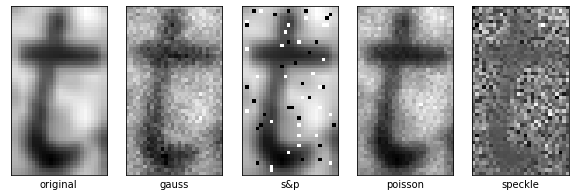

In [22]:
i = 0

original = x_train[i]
gauss = noisy(x_train[i], "gauss")
salt_n_pepper = noisy(x_train[i], "s&p")
poisson = noisy(x_train[i], "poisson")
speckle = noisy(x_train[i], "speckle")

fig_size = 10
plt.figure(figsize=(fig_size, fig_size))

j = 0

for img, noise_type in [(original, "original"), (gauss, "gauss"), (salt_n_pepper, "s&p"), (poisson, "poisson"), (speckle, "speckle")]:
    plt.subplot(1, 5, j+1)
    j += 1
    
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap="gray")
    
    plt.xlabel(noise_type)
plt.show()



## Add noisy to training set

In [25]:
%%time
l = len(x_train)
for i in range(l):
    x = x_train[i]
    y = y_train[i]
    noisy_img = noisy(x)
    append_to_training(noisy_img, y)
print("Added additional " + str(l) + " images (noisy images) to training set")

<ipython-input-11-6dcff72eb573>:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-11-6dcff72eb573>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


Added additional 97888 images (noisy images) to training set
CPU times: user 8.84 s, sys: 1.06 s, total: 9.91 s
Wall time: 9.92 s


6


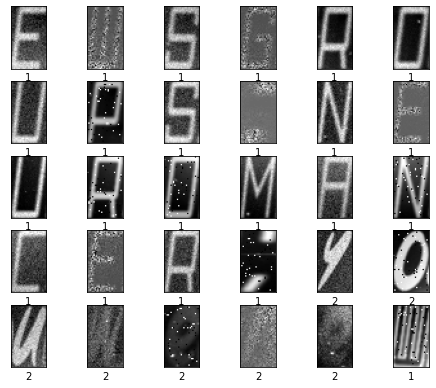

In [15]:
plot_train_samples(low=17050, high=17080)

### Example extract_data

Notice the train image is more 'blurred' (the 't' char) it's because of resize image to higher resolution


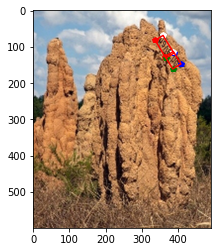

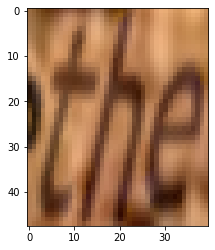

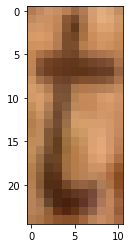

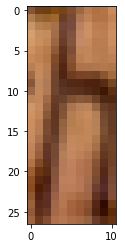

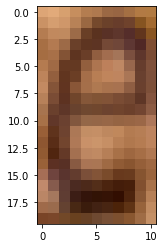

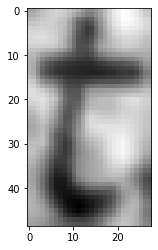

In [26]:
img_name = IM_NAMES[0]
img = db['data'][img_name][:]
plt.figure()
plt.imshow(img)
wordBB = db['data'][img_name].attrs['wordBB']

draw_bb(wordBB)

res = extract_data(img_name)

plt.figure()
plt.imshow(res["words"][0]["crop"])

word = res["words"][0]

for char in word["chars"]:
    plt.figure()
    plt.imshow(char["crop"])

plt.figure()
plt.imshow(x_train[0], cmap="gray")
print("Notice the train image is more 'blurred' (the 't' char) it's because of resize image to higher resolution")

## Pyramid of Gaussian example

Original


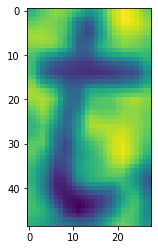

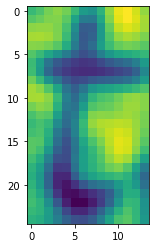

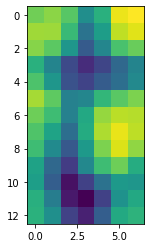

Original


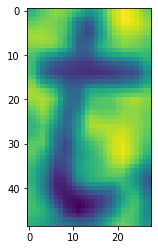

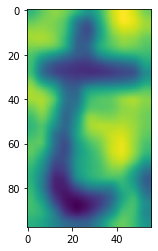

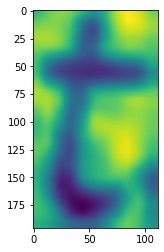

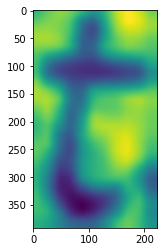

In [17]:
img = x_train[0]

print("Original")
plt.figure()
plt.imshow(img)
plt.show()

img = cv2.pyrDown(img)
plt.figure()
plt.imshow(img)
plt.show()

img = cv2.pyrDown(img)
plt.figure()
plt.imshow(img)
plt.show()

print("Original")
img = x_train[0]
plt.figure()
plt.imshow(img)
plt.show()

img = cv2.pyrUp(img)
plt.figure()
plt.imshow(img)

img = cv2.pyrUp(img)
plt.figure()
plt.imshow(img)

img = cv2.pyrUp(img)
plt.figure()
plt.imshow(img)

## Add pyramid of gaussian data to training data

## Create model

In [32]:
tf.keras.layers.Conv3D(filters=16, kernel_size=3, activation='relu').size

AttributeError: 'Conv3D' object has no attribute 'size'

In [35]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Flatten(input_shape=(avg_cropped_char_height,avg_cropped_char_width,1)))

#model.add(tf.keras.Input(shape=(avg_cropped_char_height,avg_cropped_char_width,1)))
#model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=(3, 3), activation="relu"))
#model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(3, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.build()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 16, 9, 96)         960       
_________________________________________________________________
dense_7 (Dense)              (None, 16, 9, 3)          291       
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


## Train

In [36]:
%%time
X = np.array(x_train)
Y = np.array(y_train)
history = model.fit(X, Y, epochs=40, validation_split=0.2) # Split 20% is validation, 80% training

Epoch 1/40


ValueError: in user code:

    /home/shlomi/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/shlomi/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/shlomi/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/shlomi/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/shlomi/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/shlomi/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/shlomi/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/shlomi/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/shlomi/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:234 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_4 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (None, 49, 28)


## Draw result for training

In [21]:
print(history.history.keys())

# summarize history for accuracy
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

## Predict

In [ ]:
plot_train_samples(low=0, high=25)

In [ ]:
%%time
prediction = model.predict(X[0:25])


for i in range(prediction.shape[0]):
    print("\nImage " + str(i))
    for font_index in range(prediction.shape[1]):
        print("Precition for " + FONTS[font_index] + " is: " + str(prediction[i, font_index]))


In [ ]:
tf.config.list_physical_devices()